In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt

In [8]:
# Define directories
dataset_dir = "dataset"
preprocessed_dir = "preprocessed_dataset"
os.makedirs(preprocessed_dir, exist_ok=True)

# Constants
RESIZE_DIM = (64, 64)
INPUT_FRAMES = 10
PRED_FRAMES = 5

def preprocess_video(video_path, output_dir, convert_to_grayscale=True):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return
        
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, RESIZE_DIM)
        if convert_to_grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)

    cap.release()
    
    if frames:
        output_path = os.path.join(output_dir, "frames.npy")
        np.save(output_path, np.array(frames))

def preprocess_dataset(dataset_dir, preprocessed_dir, convert_to_grayscale=True):
    for split in ["train", "test", "val"]:
        split_dir = os.path.join(dataset_dir, split)
        preprocessed_split_dir = os.path.join(preprocessed_dir, split)
        os.makedirs(preprocessed_split_dir, exist_ok=True)

        for action_class in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, action_class)
            preprocessed_class_dir = os.path.join(preprocessed_split_dir, action_class)
            
            for video_file in tqdm(os.listdir(class_dir), desc=f"Processing {split}/{action_class}"):
                video_path = os.path.join(class_dir, video_file)
                video_output_dir = os.path.join(preprocessed_class_dir, os.path.splitext(video_file)[0])
                preprocess_video(video_path, video_output_dir, convert_to_grayscale)

# Run preprocessing
preprocess_dataset(dataset_dir, preprocessed_dir, convert_to_grayscale=True)

Processing val/PlayingGuitar: 100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


In [9]:
class VideoFrameDataset(Dataset):
    def __init__(self, preprocessed_dir, split, input_frames=INPUT_FRAMES, pred_frames=PRED_FRAMES):
        self.root_dir = os.path.join(preprocessed_dir, split)
        self.input_frames = input_frames
        self.pred_frames = pred_frames
        self.samples = []
        
        for action_class in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, action_class)
            for video_dir in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_dir, 'frames.npy')
                if os.path.exists(video_path):
                    self.samples.append(video_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frames = np.load(self.samples[idx])
        total_frames_needed = self.input_frames + self.pred_frames
        
        if len(frames) < total_frames_needed:
            raise ValueError(f"Video {self.samples[idx]} has insufficient frames")
        
        start_idx = np.random.randint(0, len(frames) - total_frames_needed + 1)
        
        input_seq = frames[start_idx:start_idx + self.input_frames]
        target_seq = frames[start_idx + self.input_frames:start_idx + total_frames_needed]
        
        input_seq = torch.FloatTensor(input_seq).unsqueeze(1) / 255.0
        target_seq = torch.FloatTensor(target_seq).unsqueeze(1) / 255.0
        
        return input_seq, target_seq

model components

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.att = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=dropout)
        
    def forward(self, x):
        # x shape: [batch, time, patches, dim]
        batch_size, seq_len, n_patches, _ = x.shape
        
        # Combine batch and patches dimensions
        x = x.reshape(batch_size * n_patches, seq_len, self.dim)
        
        # attention (input needs to be in seq_len, batch, dim format for nn.MultiheadAttention)
        x = x.transpose(0, 1)  # [seq_len, batch*patches, dim]
        attn_output, _ = self.att(x, x, x)
        
        # Reshape back to original format
        attn_output = attn_output.transpose(0, 1)  # [batch*patches, seq_len, dim]
        attn_output = attn_output.reshape(batch_size, n_patches, seq_len, self.dim)
        attn_output = attn_output.transpose(1, 2)  # [batch, seq_len, patches, dim]
        
        return attn_output



class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class VideoPatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=8, emb_size=128):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', 
                     p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x):
        return self.projection(x)

main model

In [11]:

class VideoTransformer(nn.Module):
    def __init__(self, in_channels=1, img_size=64, patch_size=8, emb_dim=128,
                 n_layers=6, n_heads=8, dropout=0.1, input_frames=10, 
                 pred_frames=5):
        super().__init__()
        
        self.patch_size = patch_size
        self.input_frames = input_frames
        self.pred_frames = pred_frames
        self.num_patches = (img_size // patch_size) ** 2
        
        # Embedding layers
        self.patch_embed = VideoPatchEmbedding(in_channels, patch_size, emb_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, input_frames, self.num_patches, emb_dim))
        
        # Transformer layers
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            self.layers.append(nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads=n_heads, dropout=dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim * 4, dropout=dropout)))
            ))
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, patch_size * patch_size * in_channels),
            Rearrange('b t (h w) (p1 p2 c) -> b t c (h p1) (w p2)',
                     h=img_size//patch_size, w=img_size//patch_size,
                     p1=patch_size, p2=patch_size)
        )

    def forward(self, x):
        # x shape: [batch, time, channel, height, width]
        b = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # [batch, time, patches, dim]
        x = x + self.pos_embedding
        
        # Apply transformer layers
        for layer in self.layers:
            x = layer(x)
        
        # Generate future frames
        pred_frames = []
        curr_input = x
        
        for _ in range(self.pred_frames):
            # Use the last time step for prediction
            last_state = curr_input[:, -1:]  # [batch, 1, patches, dim]
            next_frame = self.decoder(last_state)
            pred_frames.append(next_frame)
            
            # Embed the predicted frame
            next_embedded = self.patch_embed(next_frame)
            curr_input = torch.cat([curr_input[:, 1:], next_embedded], dim=1)
        
        return torch.cat(pred_frames, dim=1)


In [12]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for input_seq, target_seq in tqdm(dataloader, desc="Training"):
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        
        optimizer.zero_grad()
        predictions = model(input_seq)
        loss = criterion(predictions, target_seq)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for input_seq, target_seq in tqdm(dataloader, desc="Validating"):
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            predictions = model(input_seq)
            loss = criterion(predictions, target_seq)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

def generate_video(model, input_sequence, output_path, device, fps=30):
    model.eval()
    with torch.no_grad():
        predictions = model(input_sequence.unsqueeze(0).to(device))
    
    predictions = predictions.cpu().numpy().squeeze() * 255
    predictions = predictions.astype(np.uint8)
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (64, 64), False)
    for frame in predictions:
        out.write(frame)
    out.release()

In [18]:
# Initialize datasets and dataloaders
train_dataset = VideoFrameDataset(preprocessed_dir, 'train')
val_dataset = VideoFrameDataset(preprocessed_dir, 'val')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Setup device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VideoTransformer().to(device)

# Training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 100

# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')

Validating: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Epoch 1/100
Training Loss: 0.0798
Validation Loss: 0.0255


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 2/100
Training Loss: 0.0250
Validation Loss: 0.0217


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 3/100
Training Loss: 0.0223
Validation Loss: 0.0201


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 4/100
Training Loss: 0.0199
Validation Loss: 0.0172


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 5/100
Training Loss: 0.0175
Validation Loss: 0.0147


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


Epoch 6/100
Training Loss: 0.0157
Validation Loss: 0.0147


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 7/100
Training Loss: 0.0146
Validation Loss: 0.0130


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 8/100
Training Loss: 0.0145
Validation Loss: 0.0132


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 9/100
Training Loss: 0.0145
Validation Loss: 0.0132


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 10/100
Training Loss: 0.0139
Validation Loss: 0.0133


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 11/100
Training Loss: 0.0134
Validation Loss: 0.0122


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 12/100
Training Loss: 0.0132
Validation Loss: 0.0123


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 13/100
Training Loss: 0.0126
Validation Loss: 0.0120


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 14/100
Training Loss: 0.0122
Validation Loss: 0.0114


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 15/100
Training Loss: 0.0119
Validation Loss: 0.0113


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 16/100
Training Loss: 0.0120
Validation Loss: 0.0109


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 17/100
Training Loss: 0.0119
Validation Loss: 0.0112


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 18/100
Training Loss: 0.0115
Validation Loss: 0.0110


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 19/100
Training Loss: 0.0111
Validation Loss: 0.0104


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 20/100
Training Loss: 0.0114
Validation Loss: 0.0107


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 21/100
Training Loss: 0.0108
Validation Loss: 0.0102


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 22/100
Training Loss: 0.0110
Validation Loss: 0.0104


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 23/100
Training Loss: 0.0108
Validation Loss: 0.0101


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 24/100
Training Loss: 0.0104
Validation Loss: 0.0098


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 25/100
Training Loss: 0.0106
Validation Loss: 0.0106


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 26/100
Training Loss: 0.0105
Validation Loss: 0.0100


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 27/100
Training Loss: 0.0102
Validation Loss: 0.0099


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 28/100
Training Loss: 0.0105
Validation Loss: 0.0099


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 29/100
Training Loss: 0.0102
Validation Loss: 0.0098


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 30/100
Training Loss: 0.0101
Validation Loss: 0.0097


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 31/100
Training Loss: 0.0099
Validation Loss: 0.0093


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 32/100
Training Loss: 0.0099
Validation Loss: 0.0091


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 33/100
Training Loss: 0.0098
Validation Loss: 0.0095


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 34/100
Training Loss: 0.0096
Validation Loss: 0.0097


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 35/100
Training Loss: 0.0096
Validation Loss: 0.0095


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 36/100
Training Loss: 0.0097
Validation Loss: 0.0092


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 37/100
Training Loss: 0.0097
Validation Loss: 0.0098


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 38/100
Training Loss: 0.0098
Validation Loss: 0.0092


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 39/100
Training Loss: 0.0093
Validation Loss: 0.0091


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 40/100
Training Loss: 0.0092
Validation Loss: 0.0105


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 41/100
Training Loss: 0.0097
Validation Loss: 0.0089


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


Epoch 42/100
Training Loss: 0.0094
Validation Loss: 0.0090


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 43/100
Training Loss: 0.0091
Validation Loss: 0.0087


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


Epoch 44/100
Training Loss: 0.0089
Validation Loss: 0.0087


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch 45/100
Training Loss: 0.0090
Validation Loss: 0.0086


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 46/100
Training Loss: 0.0090
Validation Loss: 0.0088


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 47/100
Training Loss: 0.0089
Validation Loss: 0.0091


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 48/100
Training Loss: 0.0092
Validation Loss: 0.0093


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 49/100
Training Loss: 0.0089
Validation Loss: 0.0086


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


Epoch 50/100
Training Loss: 0.0093
Validation Loss: 0.0090


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 51/100
Training Loss: 0.0092
Validation Loss: 0.0085


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 52/100
Training Loss: 0.0087
Validation Loss: 0.0097


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 53/100
Training Loss: 0.0087
Validation Loss: 0.0088


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 54/100
Training Loss: 0.0087
Validation Loss: 0.0091


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]


Epoch 55/100
Training Loss: 0.0096
Validation Loss: 0.0086


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 56/100
Training Loss: 0.0086
Validation Loss: 0.0085


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 57/100
Training Loss: 0.0085
Validation Loss: 0.0083


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 58/100
Training Loss: 0.0081
Validation Loss: 0.0081


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 59/100
Training Loss: 0.0084
Validation Loss: 0.0079


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 60/100
Training Loss: 0.0087
Validation Loss: 0.0084


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 61/100
Training Loss: 0.0083
Validation Loss: 0.0081


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 62/100
Training Loss: 0.0090
Validation Loss: 0.0090


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 63/100
Training Loss: 0.0084
Validation Loss: 0.0081


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 64/100
Training Loss: 0.0087
Validation Loss: 0.0081


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 65/100
Training Loss: 0.0088
Validation Loss: 0.0089


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 66/100
Training Loss: 0.0086
Validation Loss: 0.0078


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 67/100
Training Loss: 0.0082
Validation Loss: 0.0079


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 68/100
Training Loss: 0.0079
Validation Loss: 0.0079


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 69/100
Training Loss: 0.0084
Validation Loss: 0.0076


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 70/100
Training Loss: 0.0083
Validation Loss: 0.0085


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 71/100
Training Loss: 0.0083
Validation Loss: 0.0079


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 72/100
Training Loss: 0.0081
Validation Loss: 0.0077


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 73/100
Training Loss: 0.0081
Validation Loss: 0.0083


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 74/100
Training Loss: 0.0083
Validation Loss: 0.0080


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 75/100
Training Loss: 0.0079
Validation Loss: 0.0077


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


Epoch 76/100
Training Loss: 0.0079
Validation Loss: 0.0080


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 77/100
Training Loss: 0.0080
Validation Loss: 0.0074


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 78/100
Training Loss: 0.0082
Validation Loss: 0.0075


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 79/100
Training Loss: 0.0079
Validation Loss: 0.0076


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


Epoch 80/100
Training Loss: 0.0079
Validation Loss: 0.0082


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 81/100
Training Loss: 0.0078
Validation Loss: 0.0077


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 82/100
Training Loss: 0.0080
Validation Loss: 0.0075


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 83/100
Training Loss: 0.0078
Validation Loss: 0.0083


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 84/100
Training Loss: 0.0078
Validation Loss: 0.0077


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 85/100
Training Loss: 0.0080
Validation Loss: 0.0076


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 86/100
Training Loss: 0.0077
Validation Loss: 0.0078


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 87/100
Training Loss: 0.0078
Validation Loss: 0.0078


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 88/100
Training Loss: 0.0076
Validation Loss: 0.0073


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 89/100
Training Loss: 0.0085
Validation Loss: 0.0074


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 90/100
Training Loss: 0.0077
Validation Loss: 0.0075


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 91/100
Training Loss: 0.0075
Validation Loss: 0.0071


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 92/100
Training Loss: 0.0078
Validation Loss: 0.0084


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 93/100
Training Loss: 0.0078
Validation Loss: 0.0069


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 94/100
Training Loss: 0.0078
Validation Loss: 0.0077


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 95/100
Training Loss: 0.0078
Validation Loss: 0.0077


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 96/100
Training Loss: 0.0077
Validation Loss: 0.0072


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 97/100
Training Loss: 0.0081
Validation Loss: 0.0072


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 98/100
Training Loss: 0.0076
Validation Loss: 0.0077


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 99/100
Training Loss: 0.0077
Validation Loss: 0.0070


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 100/100
Training Loss: 0.0074
Validation Loss: 0.0075


Saving the output

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from einops.layers.torch import Rearrange
from tqdm import tqdm

In [13]:
# First, initialize your model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VideoTransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


In [14]:
checkpoint = torch.load('checkpoint_epoch_100.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


/tmp/ipykernel_7430/1595766600.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_epoch_100.pth')


In [15]:
torch.save(model, 'VisualTransformer.pth')


Grid visualization saved to sequence_grid.png


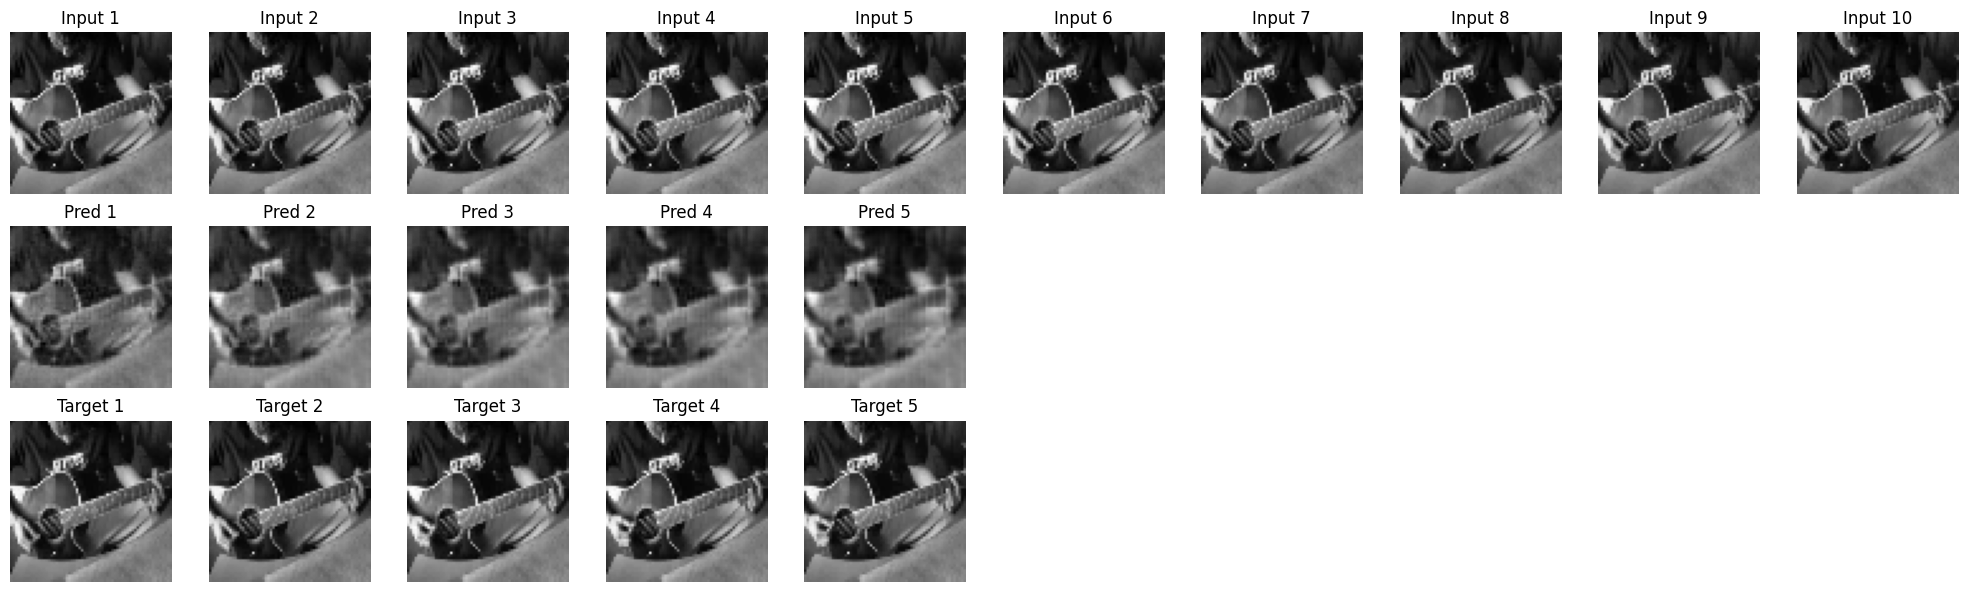


Prediction Metrics:
MSE: 0.0058
PSNR: 22.35 dB
SSIM: 0.7796


In [21]:
def visualize_sequence_grid(input_frames, predicted_frames, target_frames=None, save_path=None):
    """
    Creates a grid visualization of input and predicted frames (and optionally target frames)
    
    Args:
        input_frames (torch.Tensor): Input sequence [B, T, C, H, W] or [T, C, H, W]
        predicted_frames (torch.Tensor): Predicted sequence [B, T, C, H, W] or [T, C, H, W]
        target_frames (torch.Tensor, optional): Target sequence [B, T, C, H, W] or [T, C, H, W]
        save_path (str, optional): Path to save the visualization
    """
    # Ensure we're working with unbatched tensors
    if input_frames.dim() == 5:
        input_frames = input_frames[0]
    if predicted_frames.dim() == 5:
        predicted_frames = predicted_frames[0]
    if target_frames is not None and target_frames.dim() == 5:
        target_frames = target_frames[0]
    
    # Create figure
    num_input = len(input_frames)
    num_pred = len(predicted_frames)
    num_rows = 2 if target_frames is None else 3
    
    fig, axes = plt.subplots(num_rows, max(num_input, num_pred), 
                            figsize=(2*max(num_input, num_pred), 2*num_rows))
    
    # Plot input frames
    for i in range(max(num_input, num_pred)):
        if i < num_input:
            axes[0, i].imshow(input_frames[i].squeeze().cpu(), cmap='gray')
            axes[0, i].set_title(f'Input {i+1}')
        axes[0, i].axis('off')
    
    # Plot predicted frames
    for i in range(max(num_input, num_pred)):
        if i < num_pred:
            axes[1, i].imshow(predicted_frames[i].squeeze().cpu(), cmap='gray')
            axes[1, i].set_title(f'Pred {i+1}')
        axes[1, i].axis('off')
    
    # Plot target frames if provided
    if target_frames is not None:
        for i in range(max(num_input, num_pred)):
            if i < len(target_frames):
                axes[2, i].imshow(target_frames[i].squeeze().cpu(), cmap='gray')
                axes[2, i].set_title(f'Target {i+1}')
            axes[2, i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Grid visualization saved to {save_path}")
    
    plt.show()
# Initialize test dataset and dataloader
test_dataset = VideoFrameDataset(preprocessed_dir, 'test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
import torch.nn.functional as F
from skimage.metrics import structural_similarity

def evaluate_predictions(target_seq, predicted_seq):
    """
    Evaluates the quality of predictions using various metrics
    
    Args:
        target_seq (torch.Tensor): Ground truth sequence
        predicted_seq (torch.Tensor): Predicted sequence
        
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    with torch.no_grad():
        # Mean Squared Error
        mse = F.mse_loss(predicted_seq, target_seq).item()
        
        # Peak Signal-to-Noise Ratio (PSNR)
        mse_psnr = torch.mean((predicted_seq - target_seq) ** 2)
        psnr = 20 * torch.log10(1.0 / torch.sqrt(mse_psnr))
        
        # Structural Similarity Index (SSIM)
        ssim_val = 0
        for pred, target in zip(predicted_seq, target_seq):
            ssim_val += structural_similarity(
                pred.squeeze().cpu().numpy(),
                target.squeeze().cpu().numpy(),
                data_range=1.0
            )
        ssim_val /= len(predicted_seq)
        
    return {
        'mse': mse,
        'psnr': psnr.item(),
        'ssim': ssim_val
    }

# Now run the evaluation
model.eval()

with torch.no_grad():
    # Get a batch of test data
    input_seq, target_seq = next(iter(test_loader))
    input_seq = input_seq.to(device)
    
    # Generate predictions
    predictions = model(input_seq)
    
    # Visualize the sequences
    visualize_sequence_grid(
        input_seq,
        predictions,
        target_seq,
        save_path='sequence_grid.png'
    )

    # Print metrics
    metrics = evaluate_predictions(target_seq[0].to(device), predictions[0])
    print("\nPrediction Metrics:")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"PSNR: {metrics['psnr']:.2f} dB")
    print(f"SSIM: {metrics['ssim']:.4f}")